In [1]:
import numpy as np
import os
import pathlib
import random
import torch
import torchgeometry
import cv2
from dlclive import DLCLive, Processor

import matplotlib.pyplot as plt
from random import randrange
import random
from IPython.display import clear_output

from torch.utils.data import DataLoader

# potential mass parametrizations
from differentiable_robot_model.rigid_body_params import (
    UnconstrainedScalar,
    PositiveScalar,
    UnconstrainedTensor,
)

# potential inertia matrix parametrizations
from differentiable_robot_model.rigid_body_params import (
    CovParameterized3DInertiaMatrixNet,
    Symm3DInertiaMatrixNet,
    SymmPosDef3DInertiaMatrixNet,
    TriangParam3DInertiaMatrixNet,
)

from differentiable_robot_model.robot_model import (
    DifferentiableRobotModel,
    DifferentiableKUKAiiwa,
)
from differentiable_robot_model.data_utils import (
    generate_sine_motion_forward_dynamics_data,
)
import diff_robot_data

torch.set_printoptions(precision=3, sci_mode=False)

random.seed(0)
np.random.seed(1)
torch.manual_seed(0)


2023-07-03 09:24:55.358186: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/aman/opt/anaconda3/envs/DEEPLABCUT/lib/python3.8/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [2]:
USE_GPU = True
device = torch.device("cpu")
try:
    if USE_GPU and torch.cuda.is_available():
        device = torch.device('cuda')
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = torch.device('cpu')
except:
    if USE_GPU and torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
device = torch.device('cpu')
device

device(type='cpu')

In [3]:
class NMSELoss(torch.nn.Module):
    def __init__(self, var):
        super(NMSELoss, self).__init__()
        self.var = var

    def forward(self, yp, yt):
        err = (yp - yt) ** 2
        werr = err / self.var
        return werr.mean()

class ConstrainedTensor(torch.nn.Module):
    def __init__(self, dim1, dim2, init_tensor=None, init_std=0.1, min_val=0.0, max_val=1.0):
        super().__init__()
        self._dim1 = dim1
        self._dim2 = dim2
        if init_tensor is None:
            init_tensor = torch.empty(dim1, dim2).normal_(mean=0.0, std=init_std)
        self.param = torch.nn.Parameter(init_tensor)
        self.min_val = min_val
        self.max_val = max_val

    def forward(self):
        param = self.param
        param = torch.clamp(param, min=self.min_val, max=self.max_val)
        return param

urdf_path = os.path.join("a1.urdf")
learnable_robot_model = DifferentiableRobotModel(
    urdf_path, "A1", device=device
)

learnable_robot_model.make_link_param_learnable(
    "FR_hip", "trans", ConstrainedTensor(dim1 = 1, dim2 = 3, min_val = 0, max_val = 10)
)
learnable_robot_model.make_link_param_learnable(
        "FR_thigh_shoulder", "trans", ConstrainedTensor(dim1 = 1, dim2 = 3, min_val = 0, max_val = 10)
    )
learnable_robot_model.make_link_param_learnable(
        "FR_thigh", "trans", ConstrainedTensor(dim1 = 1, dim2 = 3, min_val = 0, max_val = 10)
    )
learnable_robot_model.make_link_param_learnable(
        "FR_calf", "trans", ConstrainedTensor(dim1 = 1, dim2 = 3, min_val = 0, max_val = 10)
    )
learnable_robot_model.make_link_param_learnable(
        "FR_foot", "trans", ConstrainedTensor(dim1 = 1, dim2 = 3, min_val = 0, max_val = 10)
    )
learnable_robot_model.make_link_param_learnable(
        "FL_hip", "trans", ConstrainedTensor(dim1 = 1, dim2 = 3, min_val = 0, max_val = 10)
    )
learnable_robot_model.make_link_param_learnable(
        "FL_thigh_shoulder", "trans", ConstrainedTensor(dim1 = 1, dim2 = 3, min_val = 0, max_val = 10)
    )
learnable_robot_model.make_link_param_learnable(
        "FL_thigh", "trans", ConstrainedTensor(dim1 = 1, dim2 = 3, min_val = 0, max_val = 10)
    )
learnable_robot_model.make_link_param_learnable(
        "FL_calf", "trans", ConstrainedTensor(dim1 = 1, dim2 = 3, min_val = 0, max_val = 10)
    )
learnable_robot_model.make_link_param_learnable(
        "FL_foot", "trans", ConstrainedTensor(dim1 = 1, dim2 = 3, min_val = 0, max_val = 10)
    )
learnable_robot_model.make_link_param_learnable(
        "RR_hip", "trans", ConstrainedTensor(dim1 = 1, dim2 = 3, min_val = 0, max_val = 10)
    )
learnable_robot_model.make_link_param_learnable(
        "RR_thigh_shoulder", "trans", ConstrainedTensor(dim1 = 1, dim2 = 3, min_val = 0, max_val = 10)
    )
learnable_robot_model.make_link_param_learnable(
        "RR_thigh", "trans", ConstrainedTensor(dim1 = 1, dim2 = 3, min_val = 0, max_val = 10)
    )
learnable_robot_model.make_link_param_learnable(
        "RR_calf", "trans", ConstrainedTensor(dim1 = 1, dim2 = 3, min_val = 0, max_val = 10)
    )
learnable_robot_model.make_link_param_learnable(
        "RR_foot", "trans", ConstrainedTensor(dim1 = 1, dim2 = 3, min_val = 0, max_val = 10)
    )
learnable_robot_model.make_link_param_learnable(
        "RL_hip", "trans", ConstrainedTensor(dim1 = 1, dim2 = 3, min_val = 0, max_val = 10)
    )
learnable_robot_model.make_link_param_learnable(
        "RL_thigh_shoulder", "trans", ConstrainedTensor(dim1 = 1, dim2 = 3, min_val = 0, max_val = 10)
    )
learnable_robot_model.make_link_param_learnable(
        "RL_thigh", "trans", ConstrainedTensor(dim1 = 1, dim2 = 3, min_val = 0, max_val = 10)
    )
learnable_robot_model.make_link_param_learnable(
        "RL_calf", "trans", ConstrainedTensor(dim1 = 1, dim2 = 3, min_val = 0, max_val = 10)
    )
learnable_robot_model.make_link_param_learnable(
        "RL_foot", "trans", ConstrainedTensor(dim1 = 1, dim2 = 3, min_val = 0, max_val = 10)
    )
pass

Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='FR_hip_tran']/actuator[@name='FR_hip_motor']
Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='FR_thigh_tran']/actuator[@name='FR_thigh_motor']
Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='FR_calf_tran']/actuator[@name='FR_calf_motor']
Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='FL_hip_tran']/actuator[@name='FL_hip_motor']
Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='FL_thigh_tran']/actuator[@name='FL_thigh_motor']
Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='FL_calf_tran']/actuator[@name='FL_calf_motor']
Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='RR_hip_tran']/actuator[@name='RR_hip_motor']
Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='RR_thigh_tran']/actuator[@name='RR_thigh_motor']
Unknown tag "hardwareInterface" 

In [4]:
keypoints = """End of Neck
Shoulder
FL_Knee
FL_Ankle
FL_White_TapeTop
FL_White_TapeBot
FR_Knee
FR_Ankle
FL_Red_TapeTop
FL_Red_TapeBot
End of Tail
Hip
BL_Knee
BL_Ankle
BL_Red_TapeTop
BL_Red_TapeBot
BR_Knee
BR_Ankle
BR_Red_TapeTop
BR_Red_TapeBot""".split("\n")
training_keypoints = ['FL_Ankle','FL_Knee','BL_Ankle','BL_Knee']
indices_keypoints_training = [keypoints.index(val) for val in training_keypoints]

base_dir = pathlib.Path.cwd()
img_path = base_dir / "HorseInferenceFiles/img0088.png"
dlc_model_path = base_dir/"HorseInferenceFiles/DLC_HorseProject1_efficientnet-b0_iteration-0_shuffle-1"
image = cv2.imread(str(img_path))
dlc_proc = Processor()
dlc_live = DLCLive(model_path=str(dlc_model_path), processor=dlc_proc)
pose = dlc_live.init_inference(image)
# X,Y coords of selected keypoints
training_data = pose[indices_keypoints_training][:,0:2]
training_data

2023-07-03 09:25:08.951295: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-03 09:25:08.982740: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


array([[275.79907, 244.88426],
       [249.62645, 216.09793],
       [340.4294 , 246.94559],
       [349.00183, 210.68068]], dtype=float32)

## Training Loop

Starting Training
Epoch 0: Loss (1524.593017578125)
Epoch 0: Loss (1524.593017578125)


<Figure size 640x480 with 0 Axes>

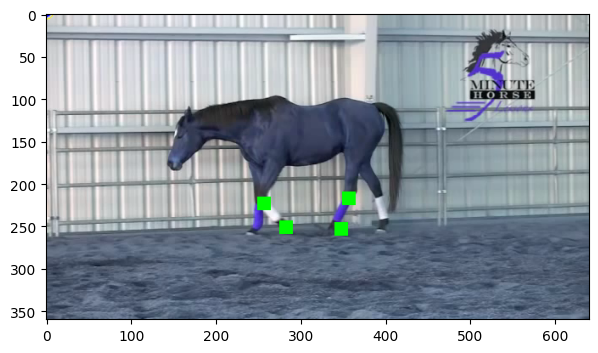

Passed Epoch 0
Passed Epoch 1
Epoch 100: Loss (1523.510009765625)
Epoch 200: Loss (1522.48583984375)
Epoch 300: Loss (1521.2340087890625)
Epoch 400: Loss (1515.6666259765625)
Epoch 500: Loss (1467.6787109375)
Epoch 600: Loss (1463.3636474609375)
Epoch 700: Loss (1458.1881103515625)
Epoch 800: Loss (1452.0584716796875)
Epoch 900: Loss (1444.645751953125)
Epoch 1000: Loss (1435.3603515625)
Epoch 1000: Loss (1435.3603515625)


<Figure size 640x480 with 0 Axes>

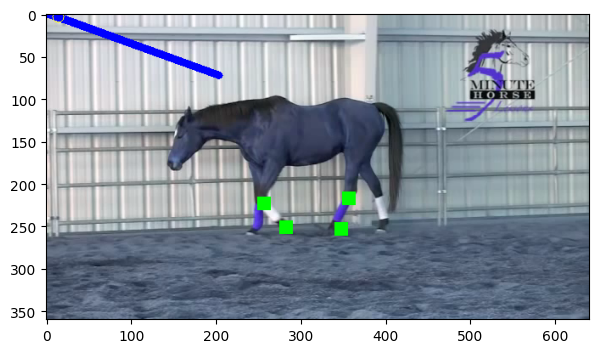

Epoch 1100: Loss (1423.0277099609375)
Epoch 1200: Loss (1404.8212890625)
Epoch 1300: Loss (1370.89111328125)
Epoch 1400: Loss (1171.7100830078125)
Epoch 1500: Loss (744.599609375)
Epoch 1600: Loss (743.2882690429688)
Epoch 1700: Loss (742.3048095703125)
Epoch 1800: Loss (741.2474365234375)
Epoch 1900: Loss (740.1102294921875)
Epoch 2000: Loss (738.88671875)
Epoch 2000: Loss (738.88671875)


<Figure size 640x480 with 0 Axes>

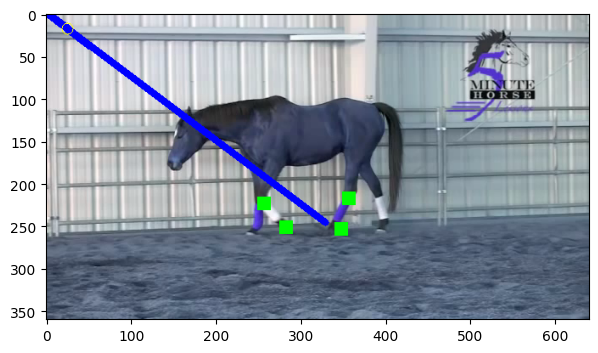

Epoch 2100: Loss (737.56982421875)
Epoch 2200: Loss (736.1515502929688)
Epoch 2300: Loss (734.62255859375)
Epoch 2400: Loss (732.9720458984375)
Epoch 2500: Loss (731.1875)
Epoch 2600: Loss (729.2821044921875)
Epoch 2700: Loss (731.4873046875)
Epoch 2800: Loss (725.1767578125)
Epoch 2900: Loss (722.835205078125)
Epoch 3000: Loss (720.2657470703125)
Epoch 3000: Loss (720.2657470703125)


<Figure size 640x480 with 0 Axes>

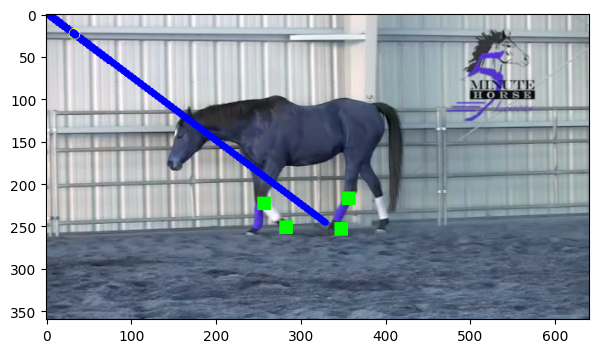

Epoch 3100: Loss (717.432373046875)
Epoch 3200: Loss (714.2899169921875)
Epoch 3300: Loss (710.7801513671875)
Epoch 3400: Loss (707.3340454101562)
Epoch 3500: Loss (703.0296020507812)
Epoch 3600: Loss (698.1944580078125)
Epoch 3700: Loss (692.5513916015625)
Epoch 3800: Loss (704.0719604492188)
Epoch 3900: Loss (678.7490844726562)
Epoch 4000: Loss (669.2760620117188)
Epoch 4000: Loss (669.2760620117188)


<Figure size 640x480 with 0 Axes>

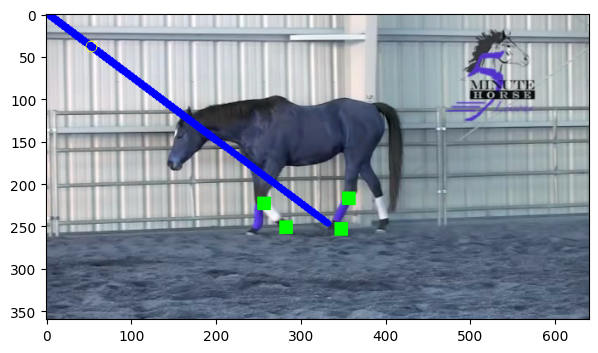

Epoch 4100: Loss (656.8489379882812)
Epoch 4200: Loss (641.300048828125)
Epoch 4300: Loss (615.9302978515625)
Epoch 4400: Loss (594.5819091796875)
Epoch 4500: Loss (406.8670349121094)
Epoch 4600: Loss (164.189697265625)
Epoch 4700: Loss (164.18614196777344)
Epoch 4800: Loss (164.18612670898438)
Epoch 4900: Loss (164.18612670898438)
Epoch 5000: Loss (164.18612670898438)
Epoch 5000: Loss (164.18612670898438)


<Figure size 640x480 with 0 Axes>

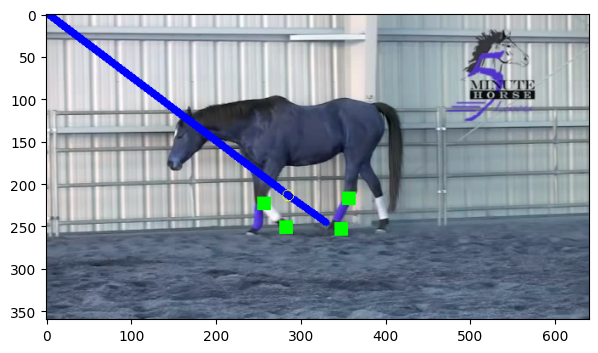

Epoch 5100: Loss (164.18612670898438)
Epoch 5200: Loss (164.18612670898438)
Epoch 5300: Loss (164.18612670898438)
Epoch 5400: Loss (164.18614196777344)
Epoch 5500: Loss (164.18614196777344)
Epoch 5600: Loss (164.18614196777344)
Epoch 5700: Loss (164.18612670898438)
Epoch 5800: Loss (164.18612670898438)
Epoch 5900: Loss (164.18612670898438)
Epoch 6000: Loss (164.18612670898438)
Epoch 6000: Loss (164.18612670898438)


<Figure size 640x480 with 0 Axes>

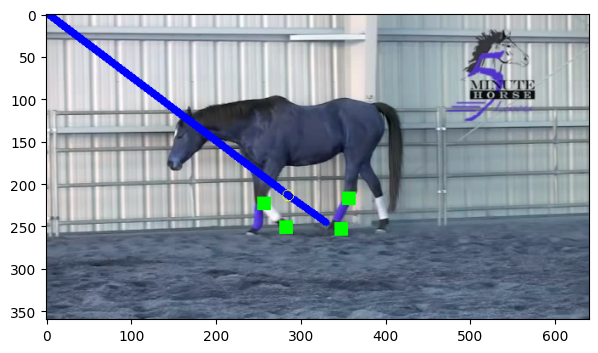

Epoch 6100: Loss (164.18612670898438)
Epoch 6200: Loss (164.18612670898438)
Epoch 6300: Loss (164.18614196777344)
Epoch 6400: Loss (164.18612670898438)
Epoch 6500: Loss (164.18612670898438)
Epoch 6600: Loss (164.18612670898438)
Epoch 6700: Loss (164.18612670898438)
Epoch 6800: Loss (164.18614196777344)
Epoch 6900: Loss (164.18612670898438)
Epoch 7000: Loss (164.18612670898438)
Epoch 7000: Loss (164.18612670898438)


<Figure size 640x480 with 0 Axes>

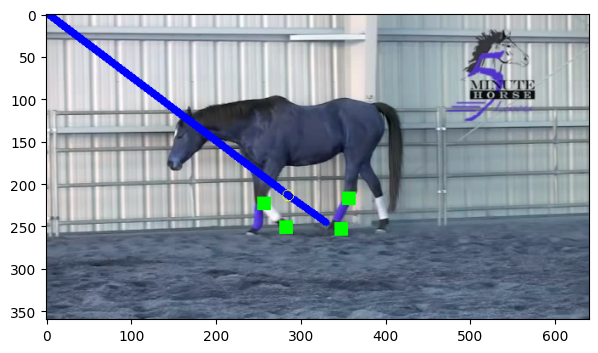

Epoch 7100: Loss (164.1861572265625)
Epoch 7200: Loss (164.18617248535156)
Epoch 7300: Loss (164.18621826171875)
Epoch 7400: Loss (164.19134521484375)
Epoch 7500: Loss (164.2642822265625)
Epoch 7600: Loss (164.21249389648438)
Epoch 7700: Loss (164.19512939453125)
Epoch 7800: Loss (164.30514526367188)
Epoch 7900: Loss (164.37600708007812)
Epoch 8000: Loss (164.37631225585938)
Epoch 8000: Loss (164.37631225585938)


<Figure size 640x480 with 0 Axes>

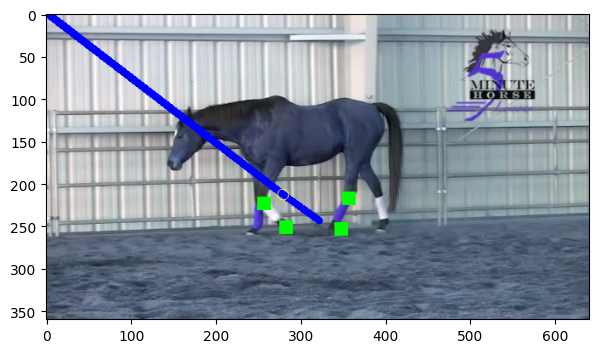

Epoch 8100: Loss (164.418212890625)
Epoch 8200: Loss (164.26739501953125)
Epoch 8300: Loss (164.19027709960938)
Epoch 8400: Loss (164.23123168945312)
Epoch 8500: Loss (177.95303344726562)
Epoch 8600: Loss (164.19264221191406)
Epoch 8700: Loss (164.18612670898438)
Epoch 8800: Loss (164.18612670898438)
Epoch 8900: Loss (164.18612670898438)
Epoch 9000: Loss (164.18612670898438)
Epoch 9000: Loss (164.18612670898438)


<Figure size 640x480 with 0 Axes>

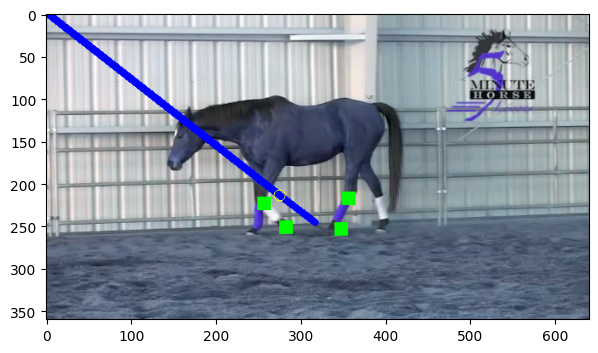

Epoch 9100: Loss (164.18612670898438)
Epoch 9200: Loss (164.18612670898438)
Epoch 9300: Loss (164.18612670898438)
Epoch 9400: Loss (164.18612670898438)
Epoch 9500: Loss (164.18612670898438)
Epoch 9600: Loss (164.18612670898438)
Epoch 9700: Loss (164.18612670898438)
Epoch 9800: Loss (164.18612670898438)
Epoch 9900: Loss (164.18612670898438)
Epoch 10000: Loss (164.18612670898438)
Epoch 10000: Loss (164.18612670898438)


<Figure size 640x480 with 0 Axes>

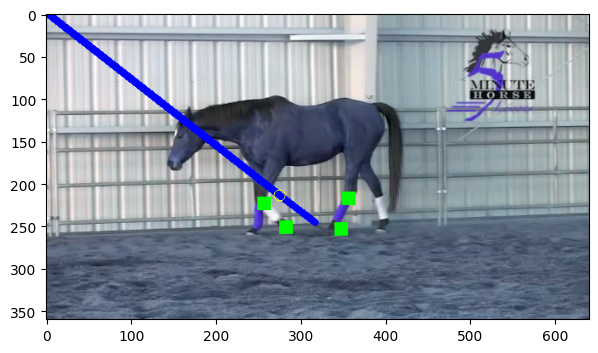

Epoch 10100: Loss (164.18612670898438)
Epoch 10200: Loss (164.18612670898438)
Epoch 10300: Loss (164.18612670898438)
Epoch 10400: Loss (164.18612670898438)
Epoch 10500: Loss (164.18612670898438)
Epoch 10600: Loss (164.18612670898438)
Epoch 10700: Loss (164.18612670898438)
Epoch 10800: Loss (164.18612670898438)
Epoch 10900: Loss (164.18614196777344)
Epoch 11000: Loss (164.18612670898438)
Epoch 11000: Loss (164.18612670898438)


<Figure size 640x480 with 0 Axes>

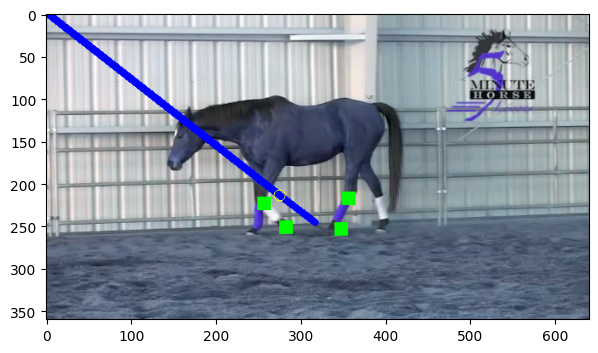

Epoch 11100: Loss (164.18612670898438)
Epoch 11200: Loss (164.18612670898438)
Epoch 11300: Loss (164.18614196777344)
Epoch 11400: Loss (164.18614196777344)
Epoch 11500: Loss (164.1861572265625)
Epoch 11600: Loss (164.18638610839844)
Epoch 11700: Loss (164.18695068359375)
Epoch 11800: Loss (164.18614196777344)
Epoch 11900: Loss (164.18612670898438)
Epoch 12000: Loss (164.18612670898438)
Epoch 12000: Loss (164.18612670898438)


<Figure size 640x480 with 0 Axes>

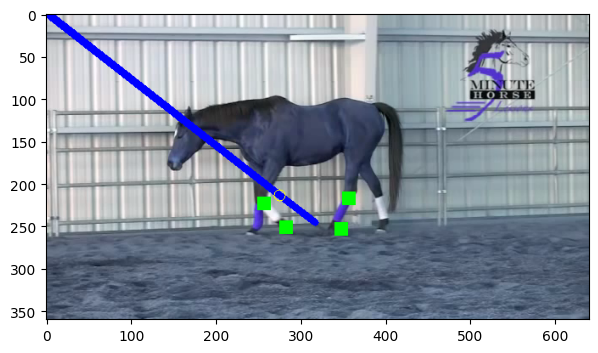

Epoch 12100: Loss (164.18612670898438)
Epoch 12200: Loss (164.18612670898438)
Epoch 12300: Loss (164.18612670898438)
Epoch 12400: Loss (164.18612670898438)
Epoch 12500: Loss (164.18612670898438)
Epoch 12600: Loss (164.18612670898438)
Epoch 12700: Loss (164.18612670898438)
Epoch 12800: Loss (164.18612670898438)
Epoch 12900: Loss (164.18612670898438)
Epoch 13000: Loss (164.18612670898438)
Epoch 13000: Loss (164.18612670898438)


<Figure size 640x480 with 0 Axes>

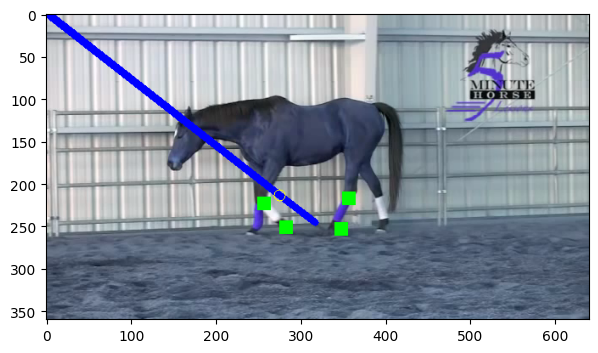

Epoch 13100: Loss (164.18612670898438)
Epoch 13200: Loss (164.18612670898438)
Epoch 13300: Loss (164.18612670898438)
Epoch 13400: Loss (164.18612670898438)
Epoch 13500: Loss (164.18612670898438)
Epoch 13600: Loss (164.18626403808594)
Epoch 13700: Loss (164.26486206054688)
Epoch 13800: Loss (164.18612670898438)
Epoch 13900: Loss (164.18612670898438)
Epoch 14000: Loss (164.18612670898438)
Epoch 14000: Loss (164.18612670898438)


<Figure size 640x480 with 0 Axes>

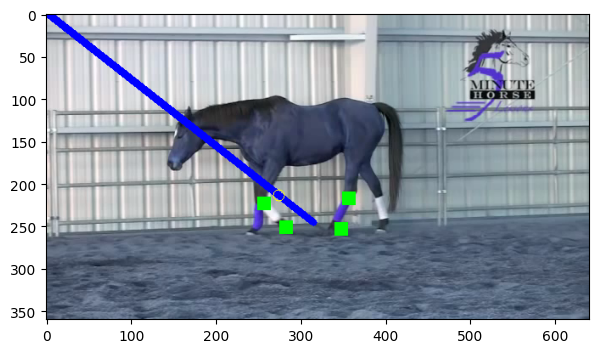

Epoch 14100: Loss (164.18612670898438)
Epoch 14200: Loss (164.18612670898438)
Epoch 14300: Loss (164.18612670898438)
Epoch 14400: Loss (164.18612670898438)
Epoch 14500: Loss (164.18612670898438)
Epoch 14600: Loss (164.18612670898438)
Epoch 14700: Loss (164.18612670898438)
Epoch 14800: Loss (164.18612670898438)
Epoch 14900: Loss (164.18612670898438)
Epoch 15000: Loss (164.18612670898438)
Epoch 15000: Loss (164.18612670898438)


<Figure size 640x480 with 0 Axes>

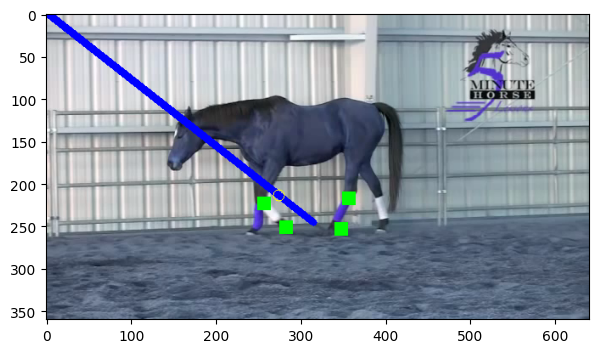

Epoch 15100: Loss (164.18614196777344)
Epoch 15200: Loss (164.18612670898438)
Epoch 15300: Loss (164.18614196777344)
Epoch 15400: Loss (164.18614196777344)
Epoch 15500: Loss (164.18614196777344)
Epoch 15600: Loss (164.18612670898438)
Epoch 15700: Loss (164.18612670898438)
Epoch 15800: Loss (164.18612670898438)
Epoch 15900: Loss (164.18612670898438)
Epoch 16000: Loss (164.18614196777344)
Epoch 16000: Loss (164.18614196777344)


<Figure size 640x480 with 0 Axes>

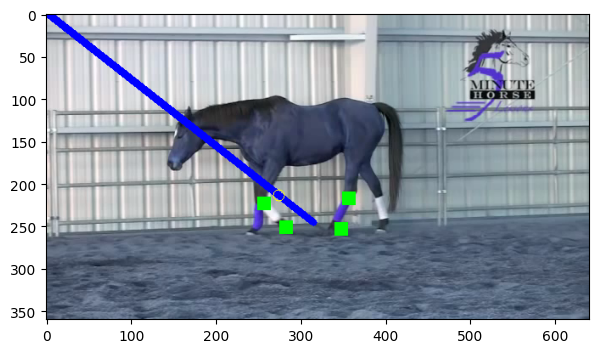

Epoch 16100: Loss (164.18614196777344)
Epoch 16200: Loss (164.18612670898438)
Epoch 16300: Loss (164.18612670898438)
Epoch 16400: Loss (164.18612670898438)
Epoch 16500: Loss (164.18612670898438)
Epoch 16600: Loss (164.18614196777344)
Epoch 16700: Loss (164.18612670898438)
Epoch 16800: Loss (164.18612670898438)
Epoch 16900: Loss (164.18614196777344)
Epoch 17000: Loss (164.18612670898438)
Epoch 17000: Loss (164.18612670898438)


<Figure size 640x480 with 0 Axes>

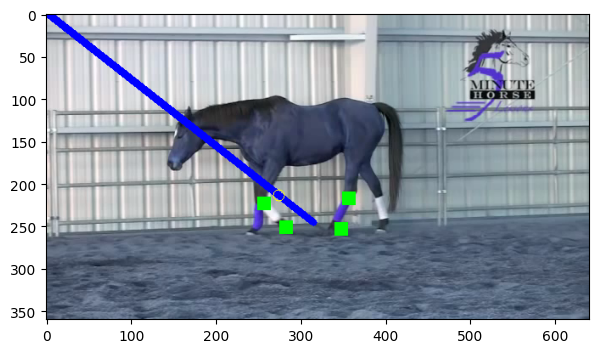

Epoch 17100: Loss (164.18612670898438)
Epoch 17200: Loss (164.18612670898438)
Epoch 17300: Loss (164.18612670898438)
Epoch 17400: Loss (164.18614196777344)
Epoch 17500: Loss (164.18612670898438)
Epoch 17600: Loss (164.18612670898438)
Epoch 17700: Loss (164.18612670898438)
Epoch 17800: Loss (164.18612670898438)
Epoch 17900: Loss (164.18612670898438)
Epoch 18000: Loss (164.18612670898438)
Epoch 18000: Loss (164.18612670898438)


<Figure size 640x480 with 0 Axes>

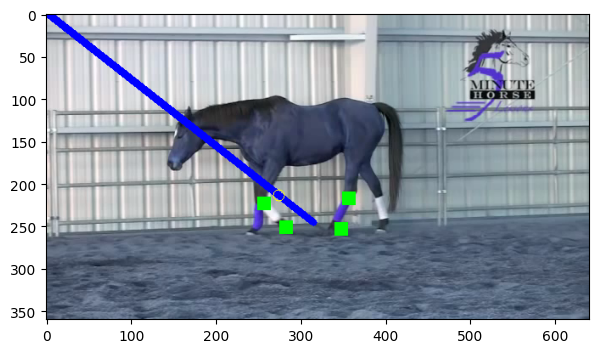

Epoch 18100: Loss (164.18612670898438)
Epoch 18200: Loss (164.18614196777344)
Epoch 18300: Loss (164.18612670898438)
Epoch 18400: Loss (164.18612670898438)
Epoch 18500: Loss (164.18612670898438)
Epoch 18600: Loss (164.18612670898438)
Epoch 18700: Loss (1223.8369140625)
Epoch 18800: Loss (164.67120361328125)
Epoch 18900: Loss (164.1861572265625)
Epoch 19000: Loss (164.18612670898438)
Epoch 19000: Loss (164.18612670898438)


<Figure size 640x480 with 0 Axes>

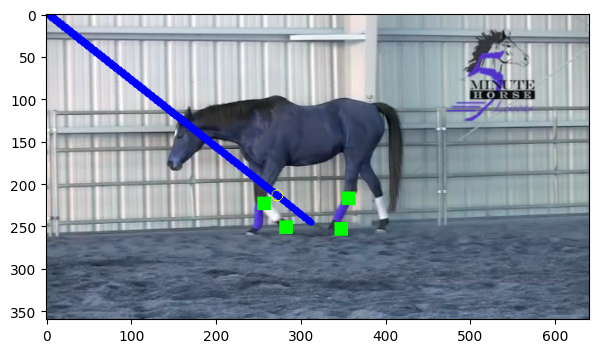

Epoch 19100: Loss (164.18612670898438)
Epoch 19200: Loss (164.18612670898438)
Epoch 19300: Loss (164.18612670898438)
Epoch 19400: Loss (164.18612670898438)
Epoch 19500: Loss (164.18612670898438)
Epoch 19600: Loss (164.18612670898438)
Epoch 19700: Loss (164.18612670898438)
Epoch 19800: Loss (164.18612670898438)
Epoch 19900: Loss (164.18612670898438)
Epoch 20000: Loss (164.18612670898438)
Epoch 20000: Loss (164.18612670898438)


<Figure size 640x480 with 0 Axes>

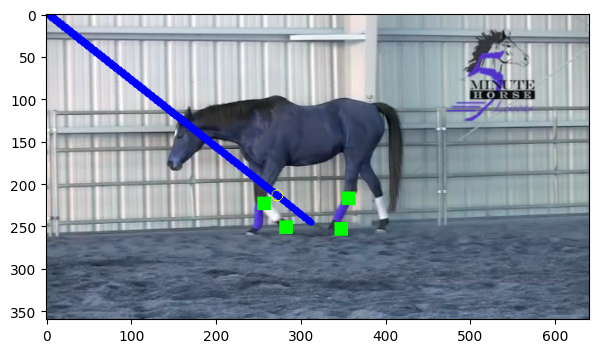

Epoch 20100: Loss (164.18612670898438)
Epoch 20200: Loss (164.18612670898438)
Epoch 20300: Loss (164.18612670898438)
Epoch 20400: Loss (164.18612670898438)
Epoch 20500: Loss (164.18612670898438)
Epoch 20600: Loss (164.18612670898438)
Epoch 20700: Loss (164.18612670898438)
Epoch 20800: Loss (164.18612670898438)
Epoch 20900: Loss (164.18612670898438)
Epoch 21000: Loss (164.18612670898438)
Epoch 21000: Loss (164.18612670898438)


<Figure size 640x480 with 0 Axes>

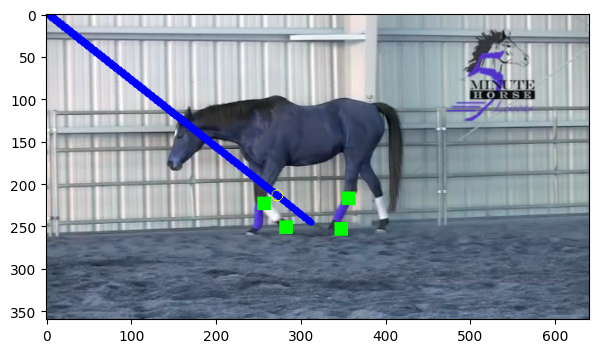

Epoch 21100: Loss (164.18612670898438)
Epoch 21200: Loss (164.18612670898438)
Epoch 21300: Loss (164.18612670898438)
Epoch 21400: Loss (164.18612670898438)
Epoch 21500: Loss (164.18612670898438)
Epoch 21600: Loss (164.18612670898438)
Epoch 21700: Loss (164.18612670898438)
Epoch 21800: Loss (164.18612670898438)
Epoch 21900: Loss (164.18612670898438)
Epoch 22000: Loss (164.18612670898438)
Epoch 22000: Loss (164.18612670898438)


<Figure size 640x480 with 0 Axes>

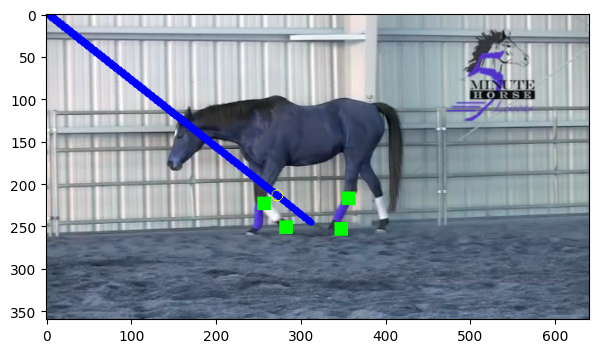

Epoch 22100: Loss (164.18612670898438)
Epoch 22200: Loss (164.18612670898438)
Epoch 22300: Loss (164.18612670898438)
Epoch 22400: Loss (164.18612670898438)
Epoch 22500: Loss (164.18614196777344)
Epoch 22600: Loss (164.18612670898438)
Epoch 22700: Loss (164.18614196777344)
Epoch 22800: Loss (164.18614196777344)
Epoch 22900: Loss (164.18612670898438)
Epoch 23000: Loss (164.18612670898438)
Epoch 23000: Loss (164.18612670898438)


<Figure size 640x480 with 0 Axes>

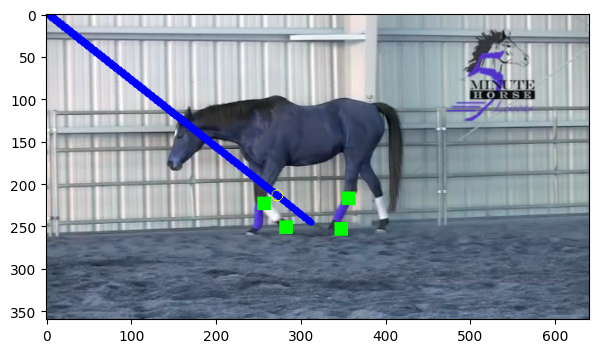

Epoch 23100: Loss (164.18614196777344)
Epoch 23200: Loss (164.18624877929688)
Epoch 23300: Loss (164.20997619628906)
Epoch 23400: Loss (164.18612670898438)
Epoch 23500: Loss (164.18612670898438)
Epoch 23600: Loss (164.18612670898438)
Epoch 23700: Loss (164.18612670898438)
Epoch 23800: Loss (164.18612670898438)
Epoch 23900: Loss (164.18612670898438)
Epoch 24000: Loss (164.18612670898438)
Epoch 24000: Loss (164.18612670898438)


<Figure size 640x480 with 0 Axes>

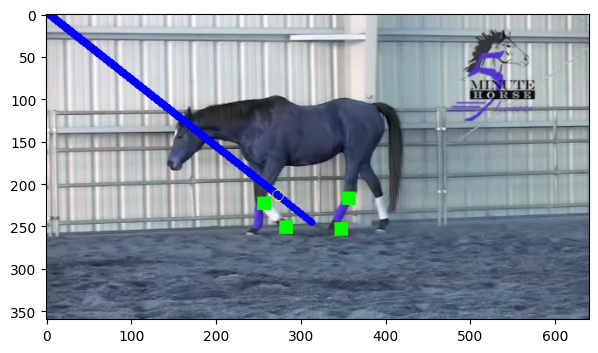

Epoch 24100: Loss (164.18612670898438)
Epoch 24200: Loss (164.18612670898438)
Epoch 24300: Loss (164.18612670898438)
Epoch 24400: Loss (164.18612670898438)
Epoch 24500: Loss (164.18612670898438)
Epoch 24600: Loss (164.18612670898438)
Epoch 24700: Loss (164.18612670898438)
Epoch 24800: Loss (164.18612670898438)
Epoch 24900: Loss (164.18612670898438)
Epoch 25000: Loss (164.18612670898438)
Epoch 25000: Loss (164.18612670898438)


<Figure size 640x480 with 0 Axes>

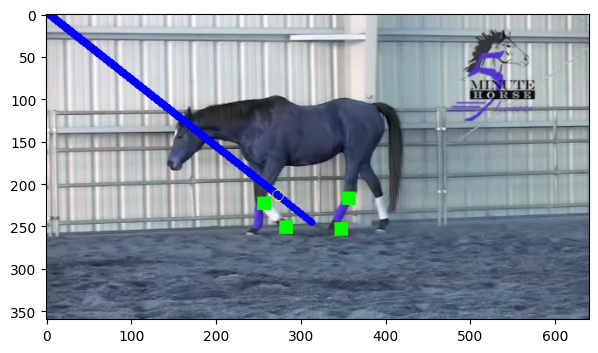

Epoch 25100: Loss (164.18612670898438)
Epoch 25200: Loss (164.18612670898438)
Epoch 25300: Loss (164.18612670898438)
Epoch 25400: Loss (164.18612670898438)
Epoch 25500: Loss (164.18612670898438)
Epoch 25600: Loss (164.18612670898438)
Epoch 25700: Loss (164.18612670898438)
Epoch 25800: Loss (164.18612670898438)
Epoch 25900: Loss (164.1861572265625)
Epoch 26000: Loss (164.18614196777344)
Epoch 26000: Loss (164.18614196777344)


<Figure size 640x480 with 0 Axes>

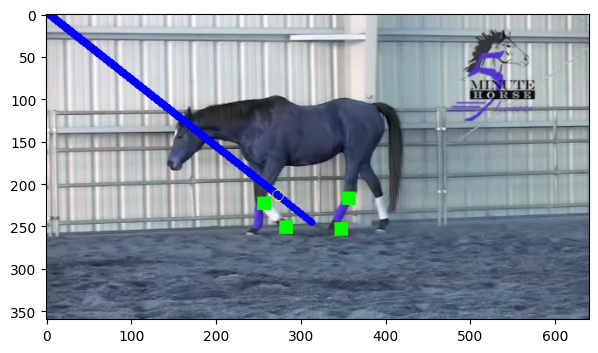

Epoch 26100: Loss (164.1862335205078)
Epoch 26200: Loss (164.20986938476562)
Epoch 26300: Loss (164.18612670898438)
Epoch 26400: Loss (164.18612670898438)
Epoch 26500: Loss (164.18614196777344)
Epoch 26600: Loss (164.18612670898438)
Epoch 26700: Loss (164.18612670898438)
Epoch 26800: Loss (164.18612670898438)
Epoch 26900: Loss (164.18612670898438)
Epoch 27000: Loss (164.18612670898438)
Epoch 27000: Loss (164.18612670898438)


<Figure size 640x480 with 0 Axes>

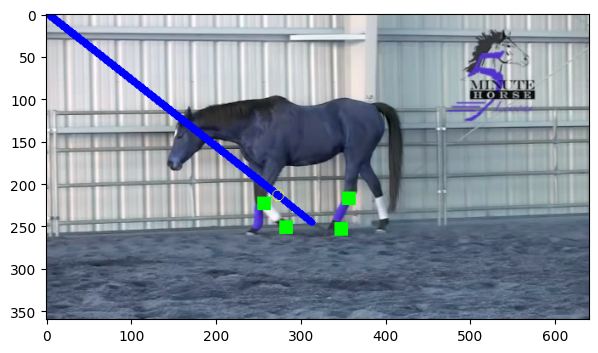

Epoch 27100: Loss (164.18612670898438)
Epoch 27200: Loss (164.18612670898438)
Epoch 27300: Loss (164.18612670898438)
Epoch 27400: Loss (164.18612670898438)
Epoch 27500: Loss (164.18612670898438)
Epoch 27600: Loss (164.18612670898438)
Epoch 27700: Loss (164.18614196777344)
Epoch 27800: Loss (164.18612670898438)
Epoch 27900: Loss (164.18612670898438)
Epoch 28000: Loss (164.18612670898438)
Epoch 28000: Loss (164.18612670898438)


<Figure size 640x480 with 0 Axes>

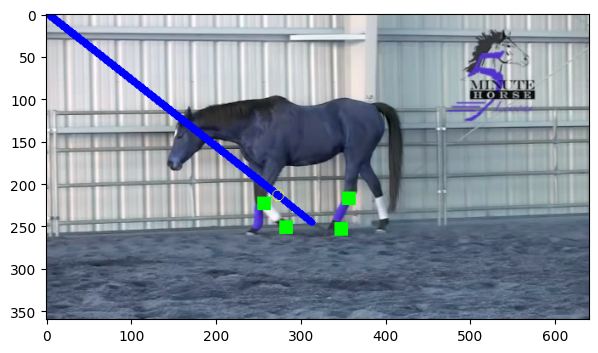

Epoch 28100: Loss (164.18612670898438)
Epoch 28200: Loss (164.18614196777344)
Epoch 28300: Loss (164.18612670898438)


KeyboardInterrupt: 

In [11]:
#Each entry is a line for the skeleton to be drawn
#Script pulls from the urdf file the links.
"""
import xml.etree.ElementTree as ET
tree = ET.parse("a1.urdf")
root = tree.getroot()
joints = root.finall(".//joint")
lines = [(joint.find("./parent").attrib.get("link"),joint.find("./child").attrib.get("link")) for joint in joints if joint.find("./parent") is not None if joint.find("./child") is not None]
"""
links = [('base', 'trunk'), ('trunk', 'imu_link'), ('trunk', 'FR_hip'), ('FR_hip', 'FR_thigh_shoulder'), ('FR_hip', 'FR_thigh'), ('FR_thigh', 'FR_calf'), ('FR_calf', 'FR_foot'), ('trunk', 'FL_hip'), ('FL_hip', 'FL_thigh_shoulder'), ('FL_hip', 'FL_thigh'), ('FL_thigh', 'FL_calf'), ('FL_calf', 'FL_foot'), ('trunk', 'RR_hip'), ('RR_hip', 'RR_thigh_shoulder'), ('RR_hip', 'RR_thigh'), ('RR_thigh', 'RR_calf'), ('RR_calf', 'RR_foot'), ('trunk', 'RL_hip'), ('RL_hip', 'RL_thigh_shoulder'), ('RL_hip', 'RL_thigh'), ('RL_thigh', 'RL_calf'), ('RL_calf', 'RL_foot')]
robot_joints_for_training = ["FL_foot", "FL_calf","RR_foot","RR_calf"]


init_angles = torch.tensor([(joint["upper"] + joint["lower"])/2 for joint in learnable_robot_model.get_joint_limits()])
joint_angles = init_angles

intrinsic = torch.Tensor([[1.0,0.0,0.0,np.random.normal(0.0,5.0)],
                          [0.0,1.0,0.0,np.random.normal(0.0,5.0)],
                          [0.0,0.0,1.0,np.random.normal(0.0,5.0)],
                          [0.0,0.0,0.0,1.0]])
extrinsic = torch.randn((1,4,4))
intrinsic = intrinsic.unsqueeze(0)
intrinsic = intrinsic.detach()
extrinsic = extrinsic.detach()
intrinsic = intrinsic.to(device).requires_grad_(True)
extrinsic = extrinsic.to(device).requires_grad_(True)

%matplotlib inline
VERBOSE = True

optimizer = torch.optim.Adam([joint_angles,intrinsic, extrinsic] + list(learnable_robot_model.parameters()), lr=1e-3)
def debugPrint(*args, **kwargs):
    if VERBOSE:
        print(*args, **kwargs)
print("Starting Training")
for epoch in range(2000000):
    optimizer.zero_grad()
    
    #Get Robot Projection
    robotEEPositions = learnable_robot_model.compute_forward_kinematics_all_links(joint_angles)
    #Prune Rotation Information 
    robotEEPositions = {linkName: robotEEPositions[linkName][0] for linkName in robotEEPositions}
    jointPosition = torch.cat([robotEEPositions[joint] for joint in robot_joints_for_training])
    reshapedJointPosition = jointPosition.reshape((1,1,-1,3))
    jointCameraPositions = torchgeometry.cam2pixel(reshapedJointPosition, intrinsic @ extrinsic)
    loss = torch.sum(torch.sqrt(torch.sum(torch.pow(jointCameraPositions - torch.from_numpy(training_data), 2),-1)))



    n = 100
    if epoch % n == 0 and VERBOSE:
        #Print every n epoch's including the 0th one
        print(f"Epoch {epoch}: Loss ({loss})")
    n = 1000
    if epoch % n == 0 and VERBOSE:
        #Print every n epoch's including the 0th one
        print(f"Epoch {epoch}: Loss ({loss})")
        img = image.copy()
        allJointPosiitons = torchgeometry.cam2pixel(torch.cat(tuple(robotEEPositions.values())).reshape((1,1,-1,3)), intrinsic@extrinsic).reshape((-1,2))
        jointToCameraPosition = {key:allJointPosiitons[index] for index,key in enumerate(robotEEPositions)}
        size = 15
        #Draw Robot Links
        for line in links:
            start,end = line[0], line[1]
            start, end = jointToCameraPosition[start], jointToCameraPosition[end]
            start = tuple(start.clone().detach().numpy())
            end = tuple(end.clone().detach().numpy())
            start = tuple((int(i) for i in start))
            end = tuple((int(i) for i in end))
            img = cv2.line(img,start, end, (0,0,255),size//2)
        #Draw Robot Joints
        for jointPositionTensor in jointToCameraPosition.values():
            jointPosition = jointToCameraPosition["base"].clone().detach().numpy()
            x,y = tuple((int(i) for i in jointPosition))
            img = cv2.circle(img,(x, y),size,(255,255,0))
        #Draw Keypoints
        for x,y in training_data:
            color = (0,255,0)
            img = cv2.rectangle(img, (int(x), int(y)),(int(x)+size, int(y)+size), color, -1)
        plt.clf()
        plt.figure(figsize=(7,5))
        plt.imshow(img)
        plt.show()
    loss.backward()
    optimizer.step()
    if epoch == 0:
        print("Passed Epoch 0")
    if epoch == 1:
        print("Passed Epoch 1")


In [ ]:
def getRobotPositionsFromJointAngles(joint_angles_array, learnable_robot_model):
    """
        Takes in joint angles array and the robot model. Outputs the 3d position of selected joints of the robot given the joint angles.
        Supports batches of joint angles.
    """
    projections = []
    #Where the Robot Thinks It Is
    for joint_angles in joint_angles_array:
        projection = torch.cat((learnable_robot_model.compute_forward_kinematics(joint_angles, "FL_foot")[0],\
        learnable_robot_model.compute_forward_kinematics(joint_angles, "FL_calf")[0],\
        learnable_robot_model.compute_forward_kinematics(joint_angles, "RR_foot")[0],\
        learnable_robot_model.compute_forward_kinematics(joint_angles, "RR_calf")[0]))
        projection = projection.unsqueeze(0).unsqueeze(0)
        projections.append(projection)
    return torch.cat(projections)

def getRobotPositionsInPixelSpace(conversionMatrix, robotPositions):
    """
        Takes in robot positions in 3D space relative to the robot. Then uses the conversion Matrix to figure out where the robot is in the pixel space of the camera. Supports batches of robotPositions.
    """
    return torchgeometry.cam2pixel(robotPositions, conversionMatrix)

def getRobotPositionInCamera(joint_angles_array, conversionMatrix, learnable_robot_model):
    return getRobotPositionsInPixelSpace(conversionMatrix, getRobotPositionsFromJointAngles(joint_angles_array, learnable_robot_model))

In [ ]:
links = learnable_robot_model.get_link_names()

In [ ]:
#Each entry is a line for the skeleton to be drawn
#Script pulls from the urdf file the links.
"""
import xml.etree.ElementTree as ET
tree = ET.parse("a1.urdf")
root = tree.getroot()
joints = root.finall(".//joint")
lines = [(joint.find("./parent").attrib.get("link"),joint.find("./child").attrib.get("link")) for joint in joints if joint.find("./parent") is not None if joint.find("./child") is not None]
"""
links = [('base', 'trunk'), ('trunk', 'imu_link'), ('trunk', 'FR_hip'), ('FR_hip', 'FR_thigh_shoulder'), ('FR_hip', 'FR_thigh'), ('FR_thigh', 'FR_calf'), ('FR_calf', 'FR_foot'), ('trunk', 'FL_hip'), ('FL_hip', 'FL_thigh_shoulder'), ('FL_hip', 'FL_thigh'), ('FL_thigh', 'FL_calf'), ('FL_calf', 'FL_foot'), ('trunk', 'RR_hip'), ('RR_hip', 'RR_thigh_shoulder'), ('RR_hip', 'RR_thigh'), ('RR_thigh', 'RR_calf'), ('RR_calf', 'RR_foot'), ('trunk', 'RL_hip'), ('RL_hip', 'RL_thigh_shoulder'), ('RL_hip', 'RL_thigh'), ('RL_thigh', 'RL_calf'), ('RL_calf', 'RL_foot')]
init_angles = torch.tensor([(joint["upper"] + joint["lower"])/2 for joint in learnable_robot_model.get_joint_limits()])
endeffector_positions = learnable_robot_model.compute_forward_kinematics_all_links(init_angles)
#Only keep the position tensor and then remove the batch dimension from it
endeffector_positions = {keypointName: endeffector_positions[keypointName][0].squeeze(0) for keypointName in endeffector_positions}
endeffectorList = learnable_robot_model.get_link_names()


intrinsic = torch.Tensor([[1.0,0.0,0.0,np.random.normal(0.0,5.0)],
                          [0.0,1.0,0.0,np.random.normal(0.0,5.0)],
                          [0.0,0.0,1.0,np.random.normal(0.0,5.0)],
                          [0.0,0.0,0.0,1.0]])
extrinsic = torch.randn((batch_size,4,4))
intrinsic = intrinsic.unsqueeze(0)
intrinsic = intrinsic.detach()
extrinsic = extrinsic.detach()
intrinsic = intrinsic.to(device).requires_grad_(True)
extrinsic = extrinsic.to(device).requires_grad_(True)

%matplotlib inline
VERBOSE = False

optimizer = torch.optim.Adam([joint_angles_array,intrinsic, extrinsic] + list(learnable_robot_model.parameters()), lr=1e-3)
def debugPrint(*args, **kwargs):
    if VERBOSE:
        print(*args, **kwargs)
print("Starting Training")
for epoch in range(2000000):
    optimizer.zero_grad()
    conversionMatrix = intrinsic @ extrinsic
    cameraEstimate = getRobotPositionInCamera(joint_angles_array, conversionMatrix, learnable_robot_model)
    debugPrint(f"Camera Estimate Shape: {cameraEstimate.shape}")
    
    #Loss Between Where Robot/Horse Should Be and Where It Is
    loss = torch.sum(torch.sqrt(torch.sum(torch.pow((training_data)-cameraEstimate, 2))))


    
    

    if VERBOSE:
        print(f"Epoch {epoch}: Loss ({loss})")
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}: Loss ({loss})")

        imgIndex = 0
        img = images[imgIndex].copy()
        random.seed(0)
        size = 15
        for x,y in training_data[imgIndex]:
            color = (randrange(0,256),randrange(0,256),randrange(0,256))
            img = cv2.rectangle(img, (int(x), int(y)),(int(x)+size, int(y)+size), color, -1)
        random.seed(0)
        for x,y in cameraEstimate[imgIndex][0]:
            color = (randrange(0,256),randrange(0,256),randrange(0,256))
            img = cv2.circle(img, (int(x), int(y)), size, color, -1)

        plt.clf()
        plt.figure(figsize=(7,5))
        plt.imshow(img)
        plt.show()
    loss.backward()
    optimizer.step()


In [ ]:
#Each entry is a line for the skeleton to be drawn
#Script pulls from the urdf file the links.
"""
import xml.etree.ElementTree as ET
tree = ET.parse("a1.urdf")
root = tree.getroot()
joints = root.finall(".//joint")
lines = [(joint.find("./parent").attrib.get("link"),joint.find("./child").attrib.get("link")) for joint in joints if joint.find("./parent") is not None if joint.find("./child") is not None]
"""
links = [('base', 'trunk'), ('trunk', 'imu_link'), ('trunk', 'FR_hip'), ('FR_hip', 'FR_thigh_shoulder'), ('FR_hip', 'FR_thigh'), ('FR_thigh', 'FR_calf'), ('FR_calf', 'FR_foot'), ('trunk', 'FL_hip'), ('FL_hip', 'FL_thigh_shoulder'), ('FL_hip', 'FL_thigh'), ('FL_thigh', 'FL_calf'), ('FL_calf', 'FL_foot'), ('trunk', 'RR_hip'), ('RR_hip', 'RR_thigh_shoulder'), ('RR_hip', 'RR_thigh'), ('RR_thigh', 'RR_calf'), ('RR_calf', 'RR_foot'), ('trunk', 'RL_hip'), ('RL_hip', 'RL_thigh_shoulder'), ('RL_hip', 'RL_thigh'), ('RL_thigh', 'RL_calf'), ('RL_calf', 'RL_foot')]
init_angles = torch.tensor([(joint["upper"] + joint["lower"])/2 for joint in learnable_robot_model.get_joint_limits()])
endeffector_positions = learnable_robot_model.compute_forward_kinematics_all_links(init_angles)
#Only keep the position tensor and then remove the batch dimension from it
endeffector_positions = {keypointName: endeffector_positions[keypointName][0].squeeze(0) for keypointName in endeffector_positions}
endeffectorList = learnable_robot_model.get_link_names()

In [ ]:
x = torch.randn(1, 3)
a = torch.cat((x,x),0).unsqueeze(0)
torch.cat((a,a,a,a),0).shape

In [ ]:
torch.tensor([(endeffectorList.index(l[0]), endeffectorList.index(l[1])) for l in links]).map

TODO:
✓ Init Joint Angles to middle of upper and lower limit.
✓ Rotation google decomposition to rotation/translation for implementation. Idea for simple POC is identity matrix for first 3 columns, then 4th column xyz randomized with z > 0, and xy around 0.
    ✓Extrinsic changes with batch
    ✓Intrinsice stays the same
✓Plot the entire robot skeleton
✓Remaking code to only go 1 image at a time for now
Add in tests for submodules
